In [99]:
import numpy as np


class CADEOutliers():
    """Class for outliers detection with CADE (Classifier Adjusted Density Estimation)"""
    
    _supported_A_dist = ["uniform"]
    
    def __init__(self, classifier, A_dist, A_size):
        """Create CADE outlier detection object.
        
        Parameters
        ----------
        classifier : model
            sklearn classifier model supporting fit and predict_proba methods.
        
        A_dist : string
            Distribution for generating artificial anomalies.
        
        A_size : float | int
            If float, then the number of artifical anomalies is |X| * A_size, where X - analyzed data. 
            If int, then the number of artifical anomalies is just A_size.
        """
        # Set classifier
        self.classifier = classifier
        
        # Set the distribution kind
        if A_dist not in self._supported_A_dist:
            raise ValueError(f"{A_dist} distribution is not supported yet for generating artifical anomalies. Choose from the following list: {self._supported_A_dist}")
        self.A_dist = A_dist
        
        # Set the number of artifical anomalies to generate
        if isinstance(A_size, int) and A_size >= 1:
            self.sample_size = A_size
        elif isinstance(A_size, float) and A_size >= 0:
            self.sample_size = None
        else:
            raise ValueError("A_size must be either int[1, inf) of float[0, inf)")
        self.A_size = A_size
        
    def _generate_A(self, dist, attrs):
        """Generate artifical anomalies.
        
        Parameters
        ----------
        dist : string
            Distribution for generating artificial anomalies.
        attrs : dict
            Key-value arguments for generating artifical anomalies. 
            If dist is "uniform", attrs = {'low': array, 'high': array, 'size': (sample_size, n_dim)} with min and high thresholds for each dimension.
        """
        if dist == 'uniform':
            generator = np.random.uniform
        else:
            raise ValueError(f"{dist} distribution is not supported yet for generating artifical anomalies. Choose from the following list: {self._supported_A_dist}")
        
        A = generator(**attrs)
        
        return A
    
    def fit(self, X):
        """Fit the distribution of X.
        
        Parameters
        ----------
        X : np.ndarray
            Array with samples
        """
        if self.sample_size is None:
            sample_size = int(len(X) * self.A_size) + 1
        else:
            sample_size = int(self.sample_size)
        
        if self.A_dist == 'uniform':
            n_dim = X.shape[1]
            attrs = {
                'low': X.min(axis=0),
                'high': X.max(axis=0),
                'size': (sample_size, n_dim)
            }
            # calculate uniform probability density
            P_A = 1
            for s in X.max(axis=0) - X.min(axis=0):
                if s == 0:
                    s = 1
                P_A /= s
            self.P_A = lambda x: np.array([P_A] * x.shape[0])
        else:
            attrs = None
            
        A = self._generate_A(self.A_dist, attrs)
        
        combined_data = np.vstack([X, A])
        target = np.hstack([np.zeros(X.shape[0]), np.ones(A.shape[0])])
        
        self.classifier.fit(combined_data, target)
        self.A_X_ratio = A.shape[0] / X.shape[0]
        
        
    def get_ranking(self, X):
        """Return rankings for each sample in X.
        Higher values indicate higher certainty that the point is an outlier.
        
        Parameters
        ----------
        X : np.ndarray
            Array with samples
        """
        predictions = self.classifier.predict_proba(X)[:, 0]
        
        anomaly_score = self.P_A(X) * self.A_X_ratio * (predictions / (1 - predictions + 1e-5))
        
        return anomaly_score

In [120]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
	('scaler', StandardScaler()),
	('classifier', LogisticRegression())
])

df_orig = pd.read_csv('data.csv', sep=';').set_index('date')
df= df_orig.copy()
for num_col in range(0,9):
	df[[df.columns[num_col]]] = StandardScaler().fit_transform(df[[df.columns[num_col]]])


cade = CADEOutliers(RandomForestClassifier(), 'uniform', df.shape[0])

In [121]:
cade.fit(df)

In [122]:
df_orig['rankings'] = cade.get_ranking(df)

c:\Users\egort\anaconda3\envs\kc_ml\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


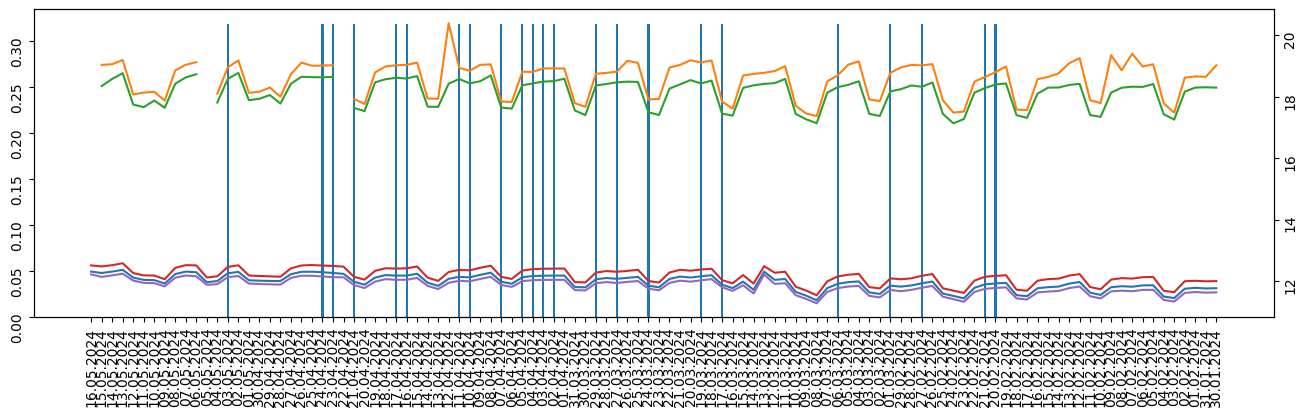

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import plotly

columns = ['cnt', 'in_rev', 'out_rev', 'sessions', 'users', 'rankings']

fig, ax1 = plt.subplots(figsize=(16, 4))
ax2 = ax1.twinx()
ax1.tick_params(labelrotation=90)
ax2.tick_params(labelrotation=90)

for column in columns:
	if column == 'rankings':
		ax1.bar(x=df_orig.index, height=df_orig[column], width=0.2)
	else:
		ax2.plot(np.log(df_orig[column]))

In [161]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.bar(df_orig['rankings']*100)
fig.update_traces(width=0.2)

columns = ['cnt', 'in_rev', 'out_rev', 'sessions', 'users']
for column in columns:
	fig.add_trace(
		go.Scatter(
			x=df_orig.index,
			y=np.log(df_orig[column]),
			mode="lines",
			name=column,
			showlegend=True)
	)
fig.show()

c:\Users\egort\anaconda3\envs\kc_ml\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

